# Предобработка

In [1482]:
import pandas as pd 
import numpy as np 
import re
import seaborn as sns
import matplotlib.pyplot as plt

In [1483]:
# Загружаем датасет: 
df = pd.read_csv('main_task_new.csv', sep=',')

In [1484]:
# Посмотрим на типы данных: 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      40000 non-null  object 
 1   City               40000 non-null  object 
 2   Cuisine Style      30717 non-null  object 
 3   Ranking            40000 non-null  float64
 4   Rating             40000 non-null  float64
 5   Price Range        26114 non-null  object 
 6   Number of Reviews  37457 non-null  float64
 7   Reviews            40000 non-null  object 
 8   URL_TA             40000 non-null  object 
 9   ID_TA              40000 non-null  object 
dtypes: float64(3), object(7)
memory usage: 3.1+ MB


Как видим, числовых данных мало, а именно 3 признака - Ranking, Rating, Number of Reviews, в то время как остальные данные являются категориальными и требуют обработки. При этом большинство данных в датасете на первый взгляд являются полными, пропуски есть в признаках Cuisine Style, Price Range, Number of Reviews. 

Для упрощения вызова колонок, переименуем их, а именно переведем названия в нижний регистр, а также уберем пробел и добавим нижнее подчеркивание: 

In [1485]:
df.columns = df.columns.str.replace(' ', '_')
df.columns = df.columns.str.lower()
df.head()

,restaurant_id,city,cuisine_style,ranking,rating,price_range,number_of_reviews,reviews,url_ta,id_ta
0,id_5569,Paris,"['European', 'French', 'International']",5570.0,3.5,$$ - $$$,194.0,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643
1,id_1535,Stockholm,NaN,1537.0,4.0,NaN,10.0,"[['Unique cuisine', 'Delicious Nepalese food']...",/Restaurant_Review-g189852-d7992032-Reviews-Bu...,d7992032
2,id_352,London,"['Japanese', 'Sushi', 'Asian', 'Grill', 'Veget...",353.0,4.5,$$$$,688.0,"[['Catch up with friends', 'Not exceptional'],...",/Restaurant_Review-g186338-d8632781-Reviews-RO...,d8632781
3,id_3456,Berlin,NaN,3458.0,5.0,NaN,3.0,"[[], []]",/Restaurant_Review-g187323-d1358776-Reviews-Es...,d1358776
4,id_615,Munich,"['German', 'Central European', 'Vegetarian Fri...",621.0,4.0,$$ - $$$,84.0,"[['Best place to try a Bavarian food', 'Nice b...",/Restaurant_Review-g187309-d6864963-Reviews-Au...,d6864963


### Для последующего анализа для начала разберемся с возникающими вопросами.
### <font color='green'>Признак price_range</font> 
Рассмотрим, какие бывают ценовые категории, и сколько их всего

In [1486]:
df['price_range'].value_counts()

$$ - $$$    18412
$            6279
$$$$         1423
Name: price_range, dtype: int64

Как видим, всего есть три ценовых категории - низкие цены (\\$) средние (\\$\\$-\\$\\$\\$) и высокие (\\$\\$\\$\\$). Также стоит отметить, что в данных о ценах есть пропуски, поэтому над ними нужно будет поработать. Заменим отсутствующие значения на значение моды, поскольку цена является ординальным признаком, заменим строковые значения на числовые. Таким образом, значения будут заменены таким образом: \\$ -1, \\$\\$-\\$\\$\\$ - 2, и \\$\\$\\$\\$ - 3, и посколько значение NaN соответствует \\$\\$-\\$\\$\\$, оно будет заменено на 2.

In [1487]:
# Сначала создадим словарь с перекодировкой признаков: 
price_dict = {np.NaN: 2, '$':1, '$$ - $$$':2, '$$$$':3}
# Применим словарь в функции replace. 
df['price_range'] = df['price_range'].replace(to_replace=price_dict)

In [1488]:
df['price_range']

0        2
1        2
2        3
3        2
4        2
        ..
39995    2
39996    2
39997    2
39998    2
39999    2
Name: price_range, Length: 40000, dtype: int64

<AxesSubplot:>

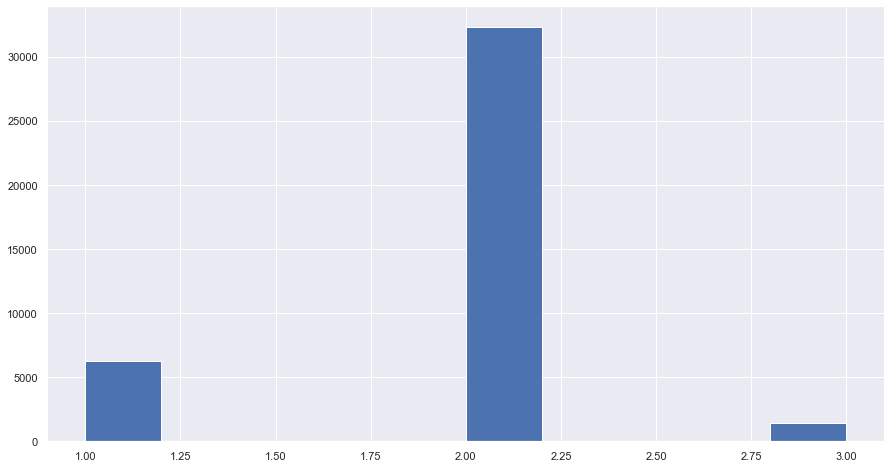

In [1489]:
# Посмотрим на гистограмму распределения
df.price_range.hist()

Как видим, большинство ресторанов находятся в среднем ценовом диапазоне (такая ситуация была и до заполнения пропусков)

### <font color='green'>Признак restaurant_id</font> 

Посчитаем, не встречаются ли некоторые рестораны больше одного раза, и не нужно ли сгруппировать данный признак

In [1490]:
restaurant_list = df.restaurant_id.value_counts()

In [1491]:
restaurant_network = restaurant_list[restaurant_list>1]

<AxesSubplot:>

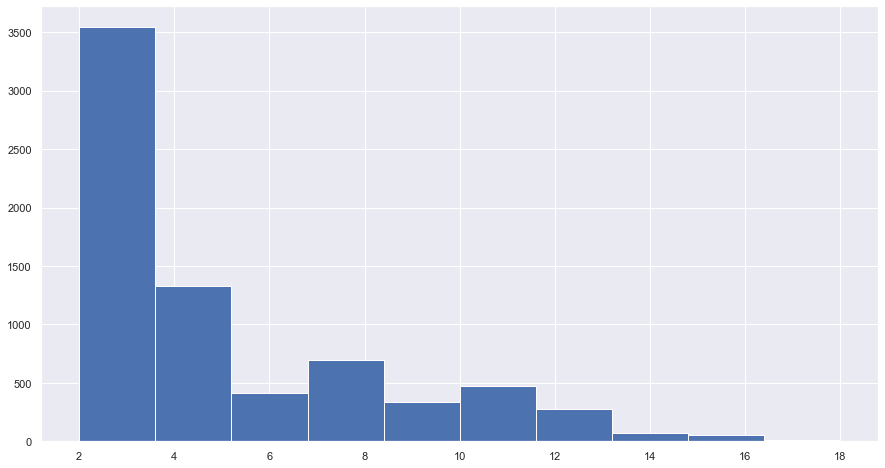

In [1492]:
restaurant_network.hist()

Как видим, большинство сетевых ресторанов - это сеть из двух ресторанов

In [1493]:
restaurant_list[restaurant_list==1].count()

4705

Количество несетевых ресторанов равно 4705

In [1494]:
df['network_restaurant'] = df['restaurant_id'].apply(lambda x: 1 if x in restaurant_network else 0)

In [1495]:
df['network_restaurant'].value_counts()

1    35295
0     4705
Name: network_restaurant, dtype: int64

###  <font color='green'>Признак city</font> 

In [1496]:
# Посчитаем сколько всего городов представлено в датасете
df['city'].value_counts().count()

31

In [1497]:
# Посмотрим какие города представлены
df['city'].value_counts()

London        5757
Paris         4897
Madrid        3108
Barcelona     2734
Berlin        2155
Milan         2133
Rome          2078
Prague        1443
Lisbon        1300
Vienna        1166
Amsterdam     1086
Brussels      1060
Hamburg        949
Munich         893
Lyon           892
Stockholm      820
Budapest       816
Warsaw         727
Dublin         673
Copenhagen     659
Athens         628
Edinburgh      596
Zurich         538
Oporto         513
Geneva         481
Krakow         443
Oslo           385
Helsinki       376
Bratislava     301
Luxembourg     210
Ljubljana      183
Name: city, dtype: int64

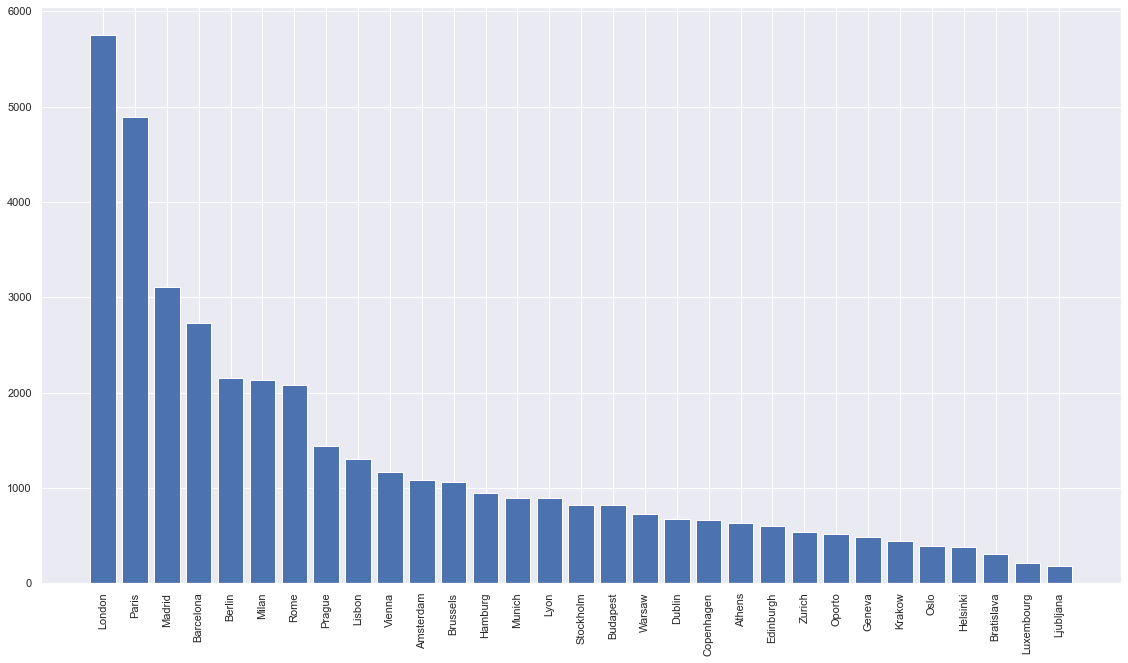

In [1498]:
# Посмотрим на распределение признаков городов: 
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(df['city'].value_counts().index, df['city'].value_counts())
plt.xticks(rotation=90)
plt.show()

In [1499]:
sns.set(rc={'figure.figsize':(15,8)})

[Text(0, 0, 'Paris'),
 Text(1, 0, 'Stockholm'),
 Text(2, 0, 'London'),
 Text(3, 0, 'Berlin'),
 Text(4, 0, 'Munich'),
 Text(5, 0, 'Oporto'),
 Text(6, 0, 'Milan'),
 Text(7, 0, 'Bratislava'),
 Text(8, 0, 'Vienna'),
 Text(9, 0, 'Rome'),
 Text(10, 0, 'Barcelona'),
 Text(11, 0, 'Madrid'),
 Text(12, 0, 'Dublin'),
 Text(13, 0, 'Brussels'),
 Text(14, 0, 'Zurich'),
 Text(15, 0, 'Warsaw'),
 Text(16, 0, 'Budapest'),
 Text(17, 0, 'Copenhagen'),
 Text(18, 0, 'Amsterdam'),
 Text(19, 0, 'Lyon'),
 Text(20, 0, 'Hamburg'),
 Text(21, 0, 'Lisbon'),
 Text(22, 0, 'Prague'),
 Text(23, 0, 'Oslo'),
 Text(24, 0, 'Helsinki'),
 Text(25, 0, 'Edinburgh'),
 Text(26, 0, 'Geneva'),
 Text(27, 0, 'Ljubljana'),
 Text(28, 0, 'Athens'),
 Text(29, 0, 'Luxembourg'),
 Text(30, 0, 'Krakow')]

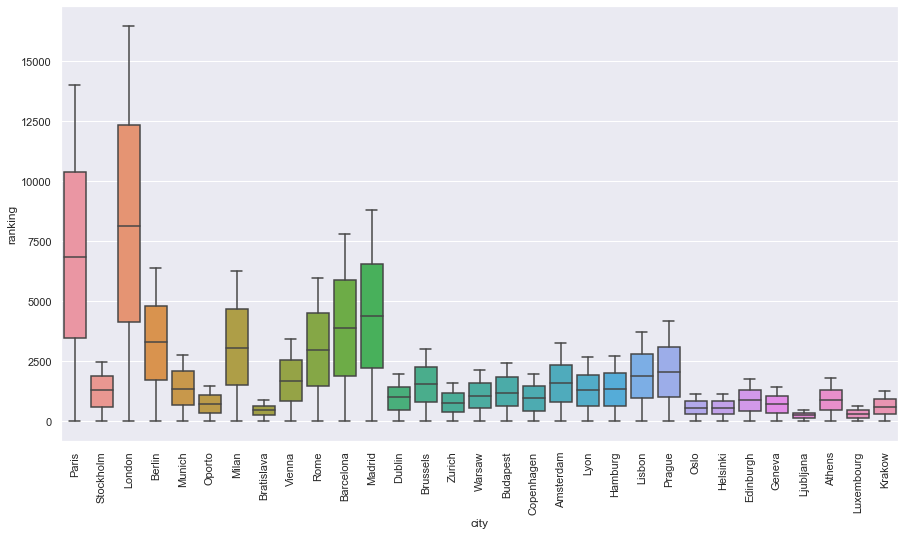

In [1500]:
a = sns.boxplot(x='city', y='ranking', data=df)
a.set_xticklabels(a.get_xticklabels(), rotation=90)

Наибольшее количество отзывов представлено о ресторанах в Лондоне, и наименьшее - в Любляне, что может быть связано с количеством населения в этих городах, и (или) востребованности туристического направления. Поскольку в этой колонке данные категориальные, переделаем их в dummy, но перед этим дополнительно обработаем. По графику видно, что ranking в городах, которые упоминаются реже в большинстве случаев ниже, чем в городах с большим количеством упоминаний. Сгруппируем эти данные

Посмотрим на распределение городов в процентом соотношении: 

In [1501]:
city_value_counts = df.city.value_counts(normalize=True)
city_value_counts

London        0.143925
Paris         0.122425
Madrid        0.077700
Barcelona     0.068350
Berlin        0.053875
Milan         0.053325
Rome          0.051950
Prague        0.036075
Lisbon        0.032500
Vienna        0.029150
Amsterdam     0.027150
Brussels      0.026500
Hamburg       0.023725
Munich        0.022325
Lyon          0.022300
Stockholm     0.020500
Budapest      0.020400
Warsaw        0.018175
Dublin        0.016825
Copenhagen    0.016475
Athens        0.015700
Edinburgh     0.014900
Zurich        0.013450
Oporto        0.012825
Geneva        0.012025
Krakow        0.011075
Oslo          0.009625
Helsinki      0.009400
Bratislava    0.007525
Luxembourg    0.005250
Ljubljana     0.004575
Name: city, dtype: float64

Сгруппируем города по количеству их упоминаний, порогом выберем 2%: 

In [1502]:
other_list = city_value_counts[city_value_counts<0.02]
other_list

Warsaw        0.018175
Dublin        0.016825
Copenhagen    0.016475
Athens        0.015700
Edinburgh     0.014900
Zurich        0.013450
Oporto        0.012825
Geneva        0.012025
Krakow        0.011075
Oslo          0.009625
Helsinki      0.009400
Bratislava    0.007525
Luxembourg    0.005250
Ljubljana     0.004575
Name: city, dtype: float64

Заменим города в списке с порогом меньше 2% на other: 

In [1503]:
df['city'] = df['city'].apply(lambda x: 'other' if x in other_list else x)

In [1504]:
df['city'].value_counts()

other        6713
London       5757
Paris        4897
Madrid       3108
Barcelona    2734
Berlin       2155
Milan        2133
Rome         2078
Prague       1443
Lisbon       1300
Vienna       1166
Amsterdam    1086
Brussels     1060
Hamburg       949
Munich        893
Lyon          892
Stockholm     820
Budapest      816
Name: city, dtype: int64

###  <font color='green'>Признак cuisine_style</font> 

In [1505]:
# Посмотрим на признак, пример
df['cuisine_style'].value_counts()

['Italian']                                                                                      1032
['French']                                                                                        805
['Spanish']                                                                                       695
['French', 'European']                                                                            405
['Cafe']                                                                                          403
                                                                                                 ... 
['Bar', 'Cafe', 'European', 'Belgian', 'Vegetarian Friendly']                                       1
['German', 'Cafe', 'International', 'Mediterranean', 'Fusion']                                      1
['Healthy', 'European', 'Vegetarian Friendly', 'Vegan Options', 'Gluten Free Options']              1
['Bar', 'Pizza', 'Mediterranean', 'Pub']                                          

Данные грязные, нужно разделить

In [1506]:
df['cuisine_style'][:][1:-1]
df['cuisine_style'] = df['cuisine_style'].apply(lambda x: x if pd.isna(x) else str(x).replace('[',''))
df['cuisine_style'] = df['cuisine_style'].apply(lambda x: x if pd.isna(x) else str(x).replace(']',''))

In [1507]:
df['cuisine_style']

0                    'European', 'French', 'International'
1                                                      NaN
2        'Japanese', 'Sushi', 'Asian', 'Grill', 'Vegeta...
3                                                      NaN
4        'German', 'Central European', 'Vegetarian Frie...
                               ...                        
39995    'Italian', 'Vegetarian Friendly', 'Vegan Optio...
39996    'French', 'American', 'Bar', 'European', 'Vege...
39997                                  'Japanese', 'Sushi'
39998    'Polish', 'European', 'Eastern European', 'Cen...
39999                                            'Spanish'
Name: cuisine_style, Length: 40000, dtype: object

In [1508]:
df['cuisine'] = df['cuisine_style'].apply(lambda x: np.nan if pd.isna(x) else str(x).split(', '))

In [1509]:
df['cuisine'].explode()

0                   'European'
0                     'French'
0              'International'
1                          NaN
2                   'Japanese'
                 ...          
39998               'European'
39998       'Eastern European'
39998       'Central European'
39998    'Vegetarian Friendly'
39999                'Spanish'
Name: cuisine, Length: 104896, dtype: object

In [1510]:
# Посчитаем сколько всего кухонь
df['cuisine'].explode().value_counts().count()

125

In [1511]:
# Среднее количество кухонь в одном ресторане
df['cuisine'].explode().index.value_counts().mean()

2.6224

In [1512]:
# Создадим признак количества кухонь в одном ресторане
df['number_cuisine'] = df['cuisine'].apply(lambda x: 1 if str(x)=='nan' else len(x))

In [1513]:
df['number_cuisine']

0        3
1        1
2        7
3        1
4        3
        ..
39995    4
39996    5
39997    2
39998    5
39999    1
Name: number_cuisine, Length: 40000, dtype: int64

<AxesSubplot:xlabel='number_cuisine', ylabel='ranking'>

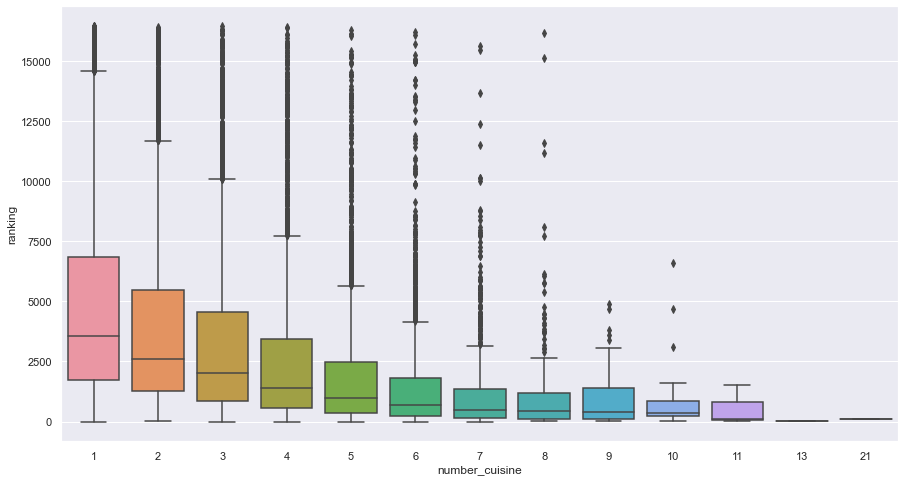

In [1514]:
sns.boxplot(x='number_cuisine', y='ranking', data=df)

Заметно, что чем более разнообразна кухня, тем менше рейтинг ресторана. 

Кухни следует перевести в дамми переменные, но перед этим попробуем сгруппировать данные по ним: 

In [1517]:
cuisine_list = df['cuisine'].explode().value_counts()
top_cuisine = cuisine_list[:10]

In [1518]:
top_cuisine

'Vegetarian Friendly'    11189
'European'               10060
'Mediterranean'           6277
'Italian'                 5964
'Vegan Options'           4486
'Gluten Free Options'     4113
'Bar'                     3297
'French'                  3190
'Asian'                   3011
'Pizza'                   2849
Name: cuisine, dtype: int64

В дальнейшем этот список понадобится для создания dummy-переменных

Поскольку в колонке <font color='green'>'cuisine'</font> присутствуют списки (<font color='purple'>list</font>), воспользуемся методом, описанным на stack overflow: https://stackoverflow.com/questions/29034928/pandas-convert-a-column-of-list-to-dummies

In [1312]:
df2 = pd.get_dummies(df['cuisine'].apply(pd.Series).stack()).sum(level=0)

In [1313]:
# Поскольку в оригинальном датасете к колонкам было сложно обращаться из-за того, что там две пары кавычек,
# приведем их к более привычному виду
df2.columns = df2.columns.str.replace("'", "")

In [1314]:
# Посмотрим что получилось в итоге
df2.head()

,Afghani,African,Albanian,American,Arabic,Argentinean,Armenian,Asian,Australian,Austrian,...,Ukrainian,Uzbek,Vegan Options,Vegetarian Friendly,Venezuelan,Vietnamese,Welsh,Wine Bar,Xinjiang,Yunnan
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,1,0,0,...,0,0,1,1,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [1315]:
# Поскольку кухонь слишком много (125), посмотрим на признак более детально
df2['Afghani'].value_counts()
df2['African'].value_counts()
df2['Albanian'].value_counts()
df2['American'].value_counts()
df2['Arabic'].value_counts()
df2['Argentinean'].value_counts()
df2['Armenian'].value_counts()
df2['Asian'].value_counts()
df2['Vegan Options'].value_counts()
df2['Ukrainian'].value_counts()
df2['Russian'].value_counts()
df2['Vegetarian Friendly'].value_counts()
df2['Afghani'].value_counts()

0    30695
1       22
Name: Afghani, dtype: int64

In [1328]:
df2.merge(df, how='right', on=None, left_on=None, right_on=None, left_index=True, right_index=True, sort=False, suffixes=('_x', '_y'), copy=True, indicator=False, validate=None)

,Afghani,African,Albanian,American,Arabic,Argentinean,Armenian,Asian,Australian,Austrian,...,city_Oslo,city_Paris,city_Prague,city_Rome,city_Stockholm,city_Vienna,city_Warsaw,city_Zurich,cuisine,number_cuisine
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,1,0,0,0,0,0,0,"['European', 'French', 'International']",3
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,1,0,0,0,NaN,1
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0,0,0,0,0,0,0,0,"['Japanese', 'Sushi', 'Asian', 'Grill', 'Veget...",7
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,NaN,1
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,"['German', 'Central European', 'Vegetarian Fri...",3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,"['Italian', 'Vegetarian Friendly', 'Vegan Opti...",4
39996,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,1,0,0,0,0,0,0,"['French', 'American', 'Bar', 'European', 'Veg...",5
39997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,1,0,0,0,"['Japanese', 'Sushi']",2
39998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,1,0,"['Polish', 'European', 'Eastern European', 'Ce...",5


<AxesSubplot:>

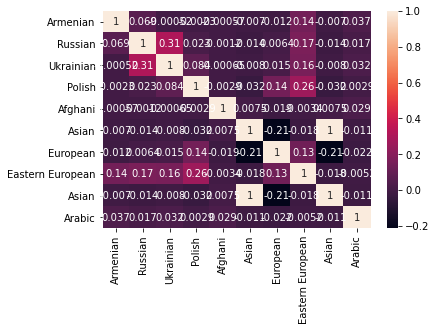

In [1329]:
sns.heatmap(df2[['Armenian','Russian', 'Ukrainian','Polish', 'Afghani','Asian','European','Eastern European','Asian', 'Arabic']].corr(), annot=True)

In [1337]:
df.city.hist()

AttributeError: 'DataFrame' object has no attribute 'city'

In [ ]:
sns.boxplot(x='Eastern European', y='ranking', data=df)

По результатам видим, что dummy-переменные действительно правильно созданы. Двигаемся дальше

In [1183]:
# Удалим колонки cuisine_style и cuisine: 
df.drop(['cuisine_style', 'cuisine'], axis=1, inplace=True)

### <font color='green'>Признак reviews</font> 

Этот признак один из самых сложных в обработке, поскольку в нем есть не только отзывы, но и их даты, поэтому для начала вытащим даты отзывов, а потом попробуем обработать сами отзывы

In [ ]:
# Посмотрим на формат отзывов: 
df['reviews']

In [ ]:
# Тип строки:
type(df['reviews'][0])

In [ ]:
# Приведет отзывы к более понятному типу: 
df['reviews'] = df['reviews'].apply(lambda x: None if pd.isna(x) else str(x).replace('[[',''))
df['reviews'] = df['reviews'].apply(lambda x: x if pd.isna(x) else str(x).replace(']]',''))
df['reviews'] = df['reviews'].apply(lambda x: x if pd.isna(x) else str(x).split('], ['))

In [ ]:
# Проверим тип строки после преобразований:
type(df['reviews'][0])

Поскольку в некоторых колонках бывают пропуски, вытащим даты отзывов при помощи регулярных выражений

In [ ]:
df['date'] = df['reviews'].apply(lambda x: x if pd.isna(str(x)) else re.findall(r'(\d{2}\/\d{2}\/\d{4})', str(x)))

In [ ]:
df['date'] = df['date'].apply(lambda x: None if len(x)==0 else x)

In [ ]:
# Выделим даты отзывов в отдельные колонки
df['date1'] = df['date'].apply(lambda x: None if x == None else x[0])
df['date0'] = df['date'].apply(lambda x: None if x == None else x[-1])

In [ ]:
# Переведем даты в формат datetime
df['date1'] = pd.to_datetime(df['date1'])
df['date0'] = pd.to_datetime(df['date0'])

In [ ]:
# Посчитаем разницу между двумя отзывами: 
df['date_difference'] = df['date1'] - df['date0']

In [ ]:
df[['date1','date0', 'date_difference']]

In [ ]:
# Переформатируем колонку date_difference в числовой формат
df["date_difference"] = (df["date_difference"]).dt.days

Какую информацию еще можно вытащить из этой колонок о дате? Можно выделить данные по разным месяцам, неделям и по времени года

In [ ]:
df['month0'] = df.date0.dt.month

In [1042]:
df['week0'] = df.date0.dt.isocalendar().week

AttributeError: 'DataFrame' object has no attribute 'date0'

In [1043]:
df['week0'].hist()

KeyError: 'week0'

In [1044]:
df['month0'].hist()

KeyError: 'month0'

In [1045]:
df['weekday0'] = df.date0.dt.weekday

AttributeError: 'DataFrame' object has no attribute 'date0'

In [1046]:
df['weekday0'].hist(bins=7)

KeyError: 'weekday0'

In [1047]:
df['month1'] = df.date1.dt.month 

AttributeError: 'DataFrame' object has no attribute 'date1'

In [1048]:
df['week1'] = df.date1.dt.isocalendar().week

AttributeError: 'DataFrame' object has no attribute 'date1'

In [1049]:
df['weekday1'] = df.date1.dt.weekday

AttributeError: 'DataFrame' object has no attribute 'date1'

In [1050]:
df['month1'].hist()

KeyError: 'month1'

In [1051]:
df['week1'].hist()

KeyError: 'week1'

In [1052]:
df['weekday1'].hist(bins=7)

KeyError: 'weekday1'

In [1053]:
# Напишем функцию для вытаскивания времени года
def time_of_year(x):
    if x in [1,2,12]:
        return 'Winter'
    elif x in [3,4,5]:
        return 'Spring'
    elif x in [6,7,8]:
        return 'Summer'
    elif x in [9,10,11]:
        return 'Fall'

In [1054]:
# Применим функцию к колонкам с месяцами оставления отзывов: 
df['time_of_year1'] = df['month1'].apply(lambda x: np.nan if pd.isna(x) else time_of_year(x))
df['time_of_year0'] = df['month0'].apply(lambda x: np.nan if pd.isna(x) else time_of_year(x))

KeyError: 'month1'

In [1055]:
df['reviews_text'] = df['reviews'].apply(lambda x: None if pd.isna(str(x)) else x[0])

In [1056]:
df['reviews_text']

0        [
1        [
2        [
3        [
4        [
        ..
39995    [
39996    [
39997    [
39998    [
39999    [
Name: reviews_text, Length: 40000, dtype: object

In [1057]:
df.drop(columns = ['date1', 'date0'])

KeyError: "['date1' 'date0'] not found in axis"

In [1058]:
df['Cuisine Style'] = df['Cuisine Style'].astype(str).str[2:-2].str.split(',')

KeyError: 'Cuisine Style'

KeyError: 'Cuisine Style'

In [1060]:
df = df_train
df.rename(columns={'Cuisine Style': 'Cuisine_Style', 'Price Range': 'Price_Range', 'Number of Reviews': 'Number_of_Reviews'}, inplace=True)
df['Number_of_Reviews_isNAN'] = pd.isna(df.Number_of_Reviews).astype('uint8')
df['Cuisine_Style_isNAN'] = pd.isna(df.Cuisine_Style).astype('uint8')
df['Price_Range_isNAN'] = pd.isna(df.Price_Range).astype('uint8')
df['Reviewse_isNAN'] = pd.isna(df.Reviews).astype('uint8')
df['Number_of_Reviews_isNAN'] = pd.isna(df['Number_of_Reviews']).astype('uint8')

# заполняем пропуски
df.Cuisine_Style.fillna('other', inplace=True)
df.Number_of_Reviews.fillna(round(df.Number_of_Reviews.mean()), inplace=True)
df.Price_Range.fillna('$$ - $$$', inplace=True)
df.Reviews.fillna('[[], []]', inplace=True)

NameError: name 'df_train' is not defined

In [ ]:
df['r1'] = df['r1'].apply(lambda x: None if x == None else x[-1])

In [60]:
df['r1']

0        [12/31/2017, 11/20/2017]
1        [07/06/2017, 06/19/2016]
2        [01/08/2018, 01/06/2018]
3                            None
4        [11/18/2017, 02/19/2017]
                   ...           
39995    [12/16/2017, 11/12/2017]
39996    [12/21/2017, 12/12/2017]
39997    [11/03/2016, 04/12/2008]
39998    [07/11/2017, 06/18/2017]
39999    [01/31/2016, 07/04/2012]
Name: r1, Length: 40000, dtype: object

In [62]:
df['r0']

0        12/31/2017
1        07/06/2017
2        01/08/2018
3              None
4        11/18/2017
            ...    
39995    12/16/2017
39996    12/21/2017
39997    11/03/2016
39998    07/11/2017
39999    01/31/2016
Name: r0, Length: 40000, dtype: object

In [ ]:
df['Cuisine Style']

In [841]:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [846]:
# Загружаем специальный инструмент для разбивки:
from sklearn.model_selection import train_test_split
X = df.drop(['restaurant_id', 'rating'], axis = 1)  
y = df['rating'] 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [849]:
# Создаём модель
regr = RandomForestRegressor(n_estimators=100)

# Обучаем модель на тестовом наборе данных
regr.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = regr.predict(X_test)

ValueError: setting an array element with a sequence.

In [858]:
corrMatrix = df.corr()
sns.heatmap(corrMatrix, annot=True)

<AxesSubplot:>

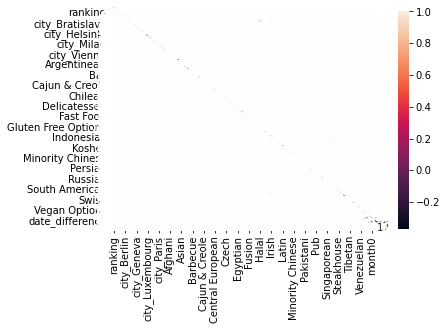

## Создаем dummy-переменные


In [1381]:
df = pd.get_dummies(df, columns = ['city'])

In [1082]:
df2.corr()

,Afghani,African,Albanian,American,Arabic,Argentinean,Armenian,Asian,Australian,Austrian,...,Ukrainian,Uzbek,Vegan Options,Vegetarian Friendly,Venezuelan,Vietnamese,Welsh,Wine Bar,Xinjiang,Yunnan
Afghani,1.000000,-0.001900,-0.000432,-0.005662,0.028798,-0.001991,-0.000572,0.007544,-0.000749,-0.002996,...,-0.000648,-0.000342,0.009604,0.010080,-0.000967,-0.003489,-0.000216,-0.004079,-0.000153,-0.000153
African,-0.001900,1.000000,-0.001146,-0.010458,-0.002895,-0.005280,-0.001516,-0.017200,-0.001985,-0.003774,...,-0.001719,-0.000906,0.013717,-0.002966,-0.002563,-0.009251,-0.000573,-0.007721,-0.000405,-0.000405
Albanian,-0.000432,-0.001146,1.000000,-0.003413,-0.000658,-0.001201,-0.000345,0.001464,-0.000451,-0.001806,...,-0.000391,-0.000206,-0.006675,-0.008025,-0.000583,-0.002103,-0.000130,0.011089,-0.000092,-0.000092
American,-0.005662,-0.010458,-0.003413,1.000000,-0.008624,-0.009207,-0.004516,-0.057819,0.028621,-0.012029,...,-0.005121,-0.002698,-0.015960,-0.018716,0.032499,-0.025051,-0.001707,-0.028985,-0.001207,-0.001207
Arabic,0.028798,-0.002895,-0.000658,-0.008624,1.000000,-0.003033,0.036593,-0.010755,-0.001140,-0.004564,...,0.032055,-0.000520,0.012571,0.005687,-0.001473,-0.005315,-0.000329,-0.000844,-0.000233,-0.000233
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Vietnamese,-0.003489,-0.009251,-0.002103,-0.025051,-0.005315,-0.009693,-0.002783,0.242396,-0.003644,-0.014586,...,-0.003156,-0.001663,0.033148,0.017492,-0.004706,1.000000,-0.001052,-0.019858,-0.000744,-0.000744
Welsh,-0.000216,-0.000573,-0.000130,-0.001707,-0.000329,-0.000600,-0.000172,-0.002660,-0.000226,-0.000903,...,-0.000195,-0.000103,0.008088,0.002276,-0.000291,-0.001052,1.000000,-0.001230,-0.000046,-0.000046
Wine Bar,-0.004079,-0.007721,0.011089,-0.028985,-0.000844,-0.005423,0.006989,-0.049497,-0.004261,0.020524,...,-0.003690,-0.001944,-0.022157,-0.006310,-0.005502,-0.019858,-0.001230,1.000000,-0.000869,-0.000869
Xinjiang,-0.000153,-0.000405,-0.000092,-0.001207,-0.000233,-0.000424,-0.000122,-0.001881,-0.000160,-0.000639,...,-0.000138,-0.000073,-0.002360,-0.004319,-0.000206,-0.000744,-0.000046,-0.000869,1.000000,-0.000033


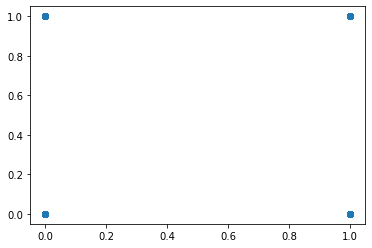

In [1092]:
import matplotlib.pyplot as plt
plt.scatter(df2['Japanese'], df2['Sushi'])
plt.show()


In [1093]:
df2[['Japanese', 'Sushi']].corr()

,Japanese,Sushi
Japanese,1.000000,0.692862
Sushi,0.692862,1.000000


In [1286]:
pip install geograpi

ERROR: Could not find a version that satisfies the requirement geograpi (from versions: none)
ERROR: No matching distribution found for geograpi
Note: you may need to restart the kernel to use updated packages.
